In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper plus tools
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect, distinct, desc

In [5]:
#create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

      #Produce a declarative base for an existing schema
Base = automap_base()

    #reflect the schema/tables
Base.prepare(engine, reflect=True)

In [7]:
# View classes that automap found

Base.classes.keys()

['measurement', 'station']

In [8]:
# save table references 

measurement_table = Base.classes.measurement

station_table = Base.classes.station

# Create the inspector and connect it to the engine

inspector = inspect(engine)

# Print the column names and datatypes

print("Measurement Table\n")

columns_measurement_table = inspector.get_columns('measurement')

for column in columns_measurement_table:
    print(column["name"], column["type"])

print("\nStation Table\n")

columns_station_table = inspector.get_columns('station')

for column in columns_station_table:
    print(column["name"], column["type"])

Measurement Table

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station Table

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Create session (link from Python to the DB)

session = Session(bind=engine)

    # verify 

session.query(measurement_table.id).first()

(1)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

    # Calculate the date 1 year ago from the last data point in the database

newestdate_query = session.query(measurement_table.date).\
                                 order_by(measurement_table.date.desc()).first()

newest_date = datetime.strptime(newestdate_query[0], "%Y-%m-%d").date()


edge_date = newest_date - timedelta(days=365)

    # Perform a query to retrieve the data and precipitation scores
    
prec_query = session.query(measurement_table.date, measurement_table.prcp).\
               filter(measurement_table.date>=edge_date).\
               all()

    # Save the query results as a Pandas DataFrame and set the index to the date column
    
        #append data to lists
        
date =[]
prec_data =[]

for record in prec_query:
    date.append(record[0])
    prec_data.append(record[1])
    
            #combine lists into dataframe
        
prec_df = pd.DataFrame((zip(date, prec_data)), 
               columns =[ 'date', 'precipitation']) 
        
            #set index
prec_df.set_index('date', inplace=True)

            #drop NaNs
prec_df.dropna(inplace=True)

    # Sort the dataframe by date
prec_df.sort_values('precipitation', ascending=False, inplace=True)

prec_df

,precipitation
date,
2016-09-14,6.70
2017-04-29,6.25
2017-02-11,5.04
2017-07-22,4.00
2016-10-04,3.46
...,...
2017-08-09,0.00
2017-08-07,0.00
2017-08-06,0.00


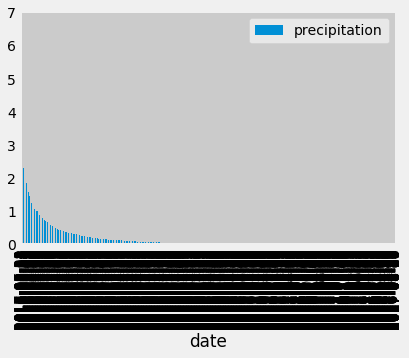

In [44]:
    # plot findings

prec_df.plot(kind='bar')

plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data

print("Precipitation - Summary statistics")

prec_df.describe()

Precipitation - Summary statistics


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
#station_count = 

print(f'number of stations: {session.query(distinct(station_table.id)).count()}')

number of stations: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
    # List the stations and the counts in descending order.

    #query
station_activity = session.query(measurement_table.station,
                                 func.count(measurement_table.station)).\
                           group_by(measurement_table.station).\
                           order_by(desc(func.count(measurement_table.station))).all()

    #into dataframe
station_activity_df = pd.DataFrame({"Station Id" : [record[0] for record in station_activity],
                                    "Activity Count" :[record[1] for record in station_activity]})

print("Number of Observations by Station\n")
station_activity_df

Number of Observations by Station



,Station Id,Activity Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [43]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

    #id of most active
most_active = session.query(measurement_table.station,
                          func.count(measurement_table.station)).\
                          group_by(measurement_table.station).\
                          order_by((func.count(measurement_table.station).desc())).\
                          first()

#query min, max and avg temp
output = session.query(func.min(measurement_table.tobs),
                        func.max(measurement_table.tobs),
                        func.avg(measurement_table.tobs)).\
                   filter(measurement_table.station == most_active[0]).all()     



stats_most_active_station = pd.DataFrame(output, columns= ["min", "max", "avg"])
                                                         

print("Most Active Station - Summary Temperature Statistics")

stats_most_active_station

Most Active Station - Summary Temperature Statistics


,min,max,avg
0,54.0,85.0,71.663781


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

    #id of most temp obs
most_temp_obs= session.query(measurement_table.station,
                            func.count(measurement_table.tobs)).\
                      group_by(measurement_table.station).\
                      order_by(desc(func.count(measurement_table.tobs))).first()
    #query
most_temp_obs_and_last_year_data = session.query(measurement_table.tobs).\
                                           filter(measurement_table.station == most_temp_obs[0]).\
                                           filter(measurement_table.date>=edge_date).\
                                           all()  

    #create list

temp_data = []

for record in most_temp_obs_and_last_year_data:
    temp_data.append(record[0])
    
temp_data

    #plot histogram
    
plt.figure(figsize=[10,8])

plt.hist(temp_data, bins=12, width = 1, color='#0504aa')
plt.xlabel('Temperature',fontsize=15, labelpad=20)
plt.ylabel('Frequency',fontsize=15, labelpad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Frequency',fontsize=15)
plt.title(f'{most_temp_obs[0]} ({edge_date} to {newest_date}) - Histogram of Temperatures',fontsize=15, pad=20)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement_table.tobs), 
                         func.avg(measurement_table.tobs), 
                         func.max(measurement_table.tobs)).\
        filter(measurement_table.date >= start_date).filter(measurement_table.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
def prec():
    print("request for precipitation data")

    # Create session 
    session = Session(engine)

    # Query the last 12 months of precipitation data. 
    results_prec = session.query(measurement_table.date, measurement_table.prcp).\
                      filter(measurement_table.date>="2016/8/23").\
                      all()

    session.close()

    # Create a dictionary from the row data and append to a list of rows
    prec_data= []
    for date, prcp in results_prec:
        prec_dict = {}
        prep_dict["date"] = date
        passenger_dict["Precipitation"] = prcp
        prec_data.append(prec_dict)

    return jsonify(prec_data)


In [ ]:
prec